## Data Access demo

## Data Access v1

[OWSLib](https://geopython.github.io/OWSLib) is a Python package for client programming with Open Geospatial Consortium (OGC) web service (hence OWS) interface standards, and their related content models. In this demo we’ll work with the CSW, WMS and WCS interfaces.

In [ ]:
from owslib.csw import CatalogueServiceWeb
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
import lxml.etree
import requests
from tifffile import imread
from io import BytesIO, StringIO

### Data Discovery

The user has already discovered the dataset to use by using the OWSLib CSW client

In [ ]:
base_domain = "develop.eoepca.org"
workspace_prefix = "ws"
system_endpoint = f'https://resource-catalogue.{base_domain}/csw'

In [ ]:
csw = CatalogueServiceWeb(system_endpoint,timeout=30)

In [ ]:
scene_id="S2B_MSIL2A_20190910T095029_N0500_R079_T33TXN_20230430T083712.SAFE"

In [ ]:
csw.getrecordbyid(id=[scene_id])

In [ ]:
links = csw.records[scene_id].references

In [ ]:
for link in links:
    scheme = link['scheme']
    if scheme and 'WMS' in scheme:
        wms_endpoint=link['url']
        print(link['url'])

### Data Visualization

After discovering the dataset, the user can identify the WMS link and use the OWSLib WMs client to visualize the dataset

In [ ]:
wms = WebMapService(wms_endpoint, version='1.3.0')

The list of layers available to the WMS service:

In [ ]:
list(wms.contents)

Along with some WMS layer metadata:

In [ ]:
wms[scene_id].title

In [ ]:
wms[scene_id].boundingBoxWGS84

In [ ]:
[op.name for op in wms.operations]

In [ ]:
wms[scene_id].styles

In [ ]:
wms.getOperationByName('GetMap').formatOptions

The user can visualize the WMS GetMap request from matplotlib

In [ ]:
%matplotlib inline
import os, sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def getMap(wms,layerName,bbox,filename,style=None):
    wms.getOperationByName('GetMap').formatOptions
    img = wms.getmap(layers=[layerName],
                 styles=[style] if style is not None else None,
                 size=(600,300),
                 srs='EPSG:4326',
                 bbox=bbox,
                 format='image/png',
                 transparent=True)

    tmpfile = open(filename,'wb')
    tmpfile.write(img.read())
    tmpfile.close()

In [ ]:
getMap(wms,f"{scene_id}__TRUE_COLOR",wms[scene_id].boundingBoxWGS84, 'rgb.png')
image1=mpimg.imread('rgb.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=wms[scene_id].boundingBoxWGS84,aspect='auto')
plt.show()

False color composite using Near Infrared, Red, Green Bands

In [ ]:
getMap(wms,f"{scene_id}__FALSE_COLOR",wms[scene_id].boundingBoxWGS84, 'nirrg.png')
image1=mpimg.imread('nirrg.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=wms[scene_id].boundingBoxWGS84,aspect='auto')
plt.show()

In [ ]:
getMap(wms,f"{scene_id}__NDVI",wms[scene_id].boundingBoxWGS84, 'ndvi.png', style='summer')
image1=mpimg.imread('ndvi.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=wms[scene_id].boundingBoxWGS84,aspect='auto')
plt.show()

In [ ]:
getMap(wms,f"{scene_id}__TRUE_COLOR",wms[scene_id].boundingBoxWGS84, 'rgb.png')
image1=mpimg.imread('rgb.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=wms[scene_id].boundingBoxWGS84,aspect='auto')
plt.show()

Alternatively, the Folium library is available to create a Leaflet map with the WMS layer

In [ ]:
import os
import folium

print(folium.__version__)

import folium.plugins.timestamped_wmstilelayer

In [ ]:
centre_lat=wms[scene_id].boundingBoxWGS84[1]+(wms[scene_id].boundingBoxWGS84[3]-wms[scene_id].boundingBoxWGS84[1])/2
centre_long=wms[scene_id].boundingBoxWGS84[0]+(wms[scene_id].boundingBoxWGS84[2]-wms[scene_id].boundingBoxWGS84[0])/2
m = folium.Map(location=[centre_lat, centre_long], zoom_start=7, tiles=None)

folium.raster_layers.WmsTileLayer(
    url="https://a.tiles.maps.eox.at",
    layers='terrain-light_3857',
    name='terrain-light',
    fmt='image/jpeg',
).add_to(m)


folium.raster_layers.WmsTileLayer(
    url=wms_endpoint.partition("?")[0],
    layers=f"{scene_id}__TRUE_COLOR",
    name=f"{scene_id}__TRUE_COLOR",
    fmt='image/png',
    transparent=True,
    overlay=True,
    control=True,
).add_to(m)

folium.raster_layers.WmsTileLayer(
    url=wms_endpoint.partition("?")[0],
    layers=f"{scene_id}__outlines",
    name=f"{scene_id}__outlines",
    fmt='image/png',
    transparent=True,
    overlay=True,
    control=True,
).add_to(m)

folium.LayerControl().add_to(m)

m

## Showing contents of a whole collection for a given timespan.

In [ ]:
m = folium.Map(location=[centre_lat, centre_long], zoom_start=6, tiles=None)

folium.raster_layers.WmsTileLayer(
    url="https://a.tiles.maps.eox.at",
    layers='terrain-light_3857',
    name='terrain-light',
    fmt='image/jpeg',
).add_to(m)

folium.raster_layers.WmsTileLayer(
    url=wms_endpoint.partition("?")[0],
    layers='S2L2A__outlines',
    name='Outlines',
    fmt='image/png',
    transparent=True,
    overlay=True,
    control=True,
    time="2019-09-10T00:00:00Z/2019-09-11T00:00:00Z",
).add_to(m)


folium.LayerControl().add_to(m)

m

### Data Download

After discovering and visualizing the dataset, the user can identify the WCS link from the catalogue record and use the OWSLib WCS client to download the dataset

In [ ]:
tree = None
for link in links:
    scheme = link['scheme']
    if scheme and 'WCS' in scheme:
        print(link['url'])
        wcs_endpoint=link['url'].split('?')[0]
        wcs_id=link['url'].split('eoid=')[1]
        tree = lxml.etree.fromstring(requests.get(link['url']).content)
        break

coverage_ids = tree.xpath('wcs:CoverageDescriptions/wcs:CoverageDescription/@gml:id', namespaces=tree.nsmap)
coverage_ids

In [ ]:
getcoverage_request = wcs_endpoint + '?service=WCS&version=2.0.1&request=GetCoverage&coverageid=' + coverage_ids[1] + '&scaleSize=x(100),y(100)&format=image/tiff'
response = requests.get(getcoverage_request)
response.raise_for_status()

content = response.content
img1 = plt.imshow(imread(BytesIO(content)),extent=[23.4,24.5,37.8,38.8],aspect='auto')
plt.show()

## Data Access v2

In [ ]:
base_domain = "develop.eoepca.org"

## Data Discovery (STAC)

In [ ]:
import json
import requests
from folium import Map, TileLayer
from pystac_client import Client

#### Define a STAC query and validate its returns

In [ ]:
# See STAC API docs at https://eoapi.develop.eoepca.org/stac/api.html
STAC_API_URL = f"https://eoapi.{base_domain}/stac"
RASTER_API_URL = f"https://eoapi.{base_domain}/raster"
COLLECTION_ID = "sentinel-2-iceland"

In [ ]:
STAC_API_URL

In [ ]:
# Search against the STAC API
catalog = Client.open(STAC_API_URL)
catalog.id

In [ ]:
# Select a collection
collections_filter = {
    "op": "=",
    "args": [{"property": "collection"}, COLLECTION_ID],
}

In [ ]:
# Define your area of interest
AOI = {
  "type": "Polygon",
  "coordinates": [
    [
      [-21.470015412404706, 63.55594801099713],
      [-20.336567910645556, 63.55594801099713],
      [-20.336567910645556, 64.17209253282897],
      [-21.470015412404706, 64.17209253282897],
      [-21.470015412404706, 63.55594801099713]
    ]
  ]
}
spatial_filter = {"op": "s_intersects", "args": [{"property": "geometry"}, AOI]}

In [ ]:
# Define your time interval of interest
TIME_INTERVAL = ["2023-07-01T00:00:00Z", "2023-07-31T23:59:59Z"]
temporal_filter = {
    "op": "t_intersects",
    "args": [{"property": "datetime"}, {"interval": TIME_INTERVAL}],
}

In [ ]:
# Additional filters can be applied for other search criteria like <= maximum eo:cloud_cover in item properties
cloud_filter = {"op": "<=", "args": [{"property": "eo:cloud_cover"}, 100]}

In [ ]:
# Define your search with CQL2 syntax
SEARCH_BODY = {
    "filter-lang": "cql2-json",
    "limit": 20,
    "sortby": [{"direction": "desc", "field": "properties.datetime"}],
    "context": "on",  # add context for a summary of matched results
    "filter": {
        "op": "and",
        "args": [collections_filter, spatial_filter, temporal_filter, cloud_filter],
    },
}

In [ ]:
# Note this search body can also be used for a stac item search

response = requests.post(
    f"{STAC_API_URL}/search",
    json=SEARCH_BODY
)
response.raise_for_status()
stac_items = response.json()

# Check how many items were matched in search
print("returned {numberReturned} out of {numberMatched} matching items".format(**stac_items))

## Visualize a Single Item With Dynamic Tiles (XYZ)

In [ ]:
first_item = stac_items["features"][0]

In [ ]:
first_item["id"]

In [ ]:
collection_id = COLLECTION_ID
item_id = first_item["id"]
response = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json",
    params={
        # Info to add to the tilejson response
        "minzoom": 9,
        "maxzoom": 12,
        "assets": ["red", "green", "blue"],
        "color_formula": "Gamma RGB 5 Saturation 0.8 Sigmoidal RGB 20 0.35",
        "nodata": 0,
    },
)
response.raise_for_status()
tilejson = response.json()

In [ ]:
tilejson

In [ ]:
map_center = tilejson["center"][:2][::-1]

In [ ]:
# Set up a map located w/in event bounds
m = Map(
    tiles="OpenStreetMap",
    location=map_center,
    zoom_start=tilejson["minzoom"],
    min_zoom=0,
    max_zoom=20
)

# Add the formatted map layer
map_layer = TileLayer(
    tiles=tilejson["tiles"][0],
    attr="Contains modified Copernicus Sentinel-2 data",
)
map_layer.add_to(m)
m

### Visualize a Spatio-Temporal Mosaic With Dynamic Tiles (XYZ)

In [ ]:
# Register a mosaic for your STAC query
response = requests.post(
    f"{RASTER_API_URL}/searches/register",
    json=SEARCH_BODY,
)
response.raise_for_status()
mosaic = response.json()
print(json.dumps(mosaic, indent=2))

In [ ]:
# Get base url for tiler from the register mosaic request
tiles_href = next(
    link["href"] for link in mosaic["links"] if link["rel"] == "tilejson"
)
# Set the tileMatrixSetId
tiles_href = tiles_href.format(**{"tileMatrixSetId": "WebMercatorQuad"})

In [ ]:
response = requests.get(
    tiles_href,
    params={
        # Info to add to the tilejson response
        "minzoom": 9,
        "maxzoom": 12,
        "assets": ["red", "green", "blue"],
        "color_formula": "Gamma RGB 5 Saturation 0.8 Sigmoidal RGB 20 0.35",
        "nodata": 0,
    },
)
response.raise_for_status()
tilejson = response.json()

In [ ]:
tilejson

In [ ]:
# Set up a map located w/in event bounds
m = Map(
    tiles="OpenStreetMap",
    location=map_center,
    zoom_start=tilejson["minzoom"],
    min_zoom=0,
    max_zoom=20
)

# Add the formatted map layer
map_layer = TileLayer(
    tiles=tilejson["tiles"][0],
    attr="Contains modified Copernicus Sentinel-2 data",
)
map_layer.add_to(m)
m

## (WIP) Protected STAC API Transaction Extension methods (POST to /collections etc.) require authorization

WIP, see https://github.com/EOEPCA/resource-discovery/issues/106

In [ ]:
base_domain = "develop.eoepca.org"

PROTECTED_STAC_API_URL = f"https://eoapi.{base_domain}/stac"

In [ ]:
import requests

In [ ]:
response = requests.get(f"{PROTECTED_STAC_API_URL}/collections")
response.raise_for_status()
assert "collections" in response.json()

In [ ]:
response = requests.post(f"{PROTECTED_STAC_API_URL}/collections")
assert response.status_code == 401  # 401 Unauthorized

## Data Visualization with Maps (OGC API Maps)

In [22]:
collection = "sentinel-2-l2a-render"
response = requests.get(f"{PROTECTED_STAC_API_URL}/collections/{collection}")
response.json()["renders"]

{'ndvi': {'title': 'NDVI Render',
  'assets': ['red', 'nir'],
  'rescale': '-1,1',
  'expression': '(nir_b1-red_b1)/(nir_b1+red_b1)',
  'colormap_name': 'coolwarm'},
 'default': {'title': 'Default TCI Render', 'assets': ['visual']}}

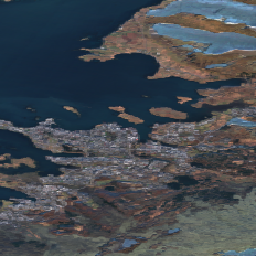

In [23]:
MAPS_API_URL = f"https://maps.{base_domain}"
import requests
from PIL import Image
from IPython.display import display
import io
params = {
    "bbox": "-22,64,-21.7,64.3",
    "datetime": "2023-10-31T00:00:00Z/2023-10-31T23:59:59Z",
    "width": 256,
    "height": 256,
}
response = requests.get(f"{MAPS_API_URL}/collections/{collection}/map", params=params)
response.raise_for_status()
img = Image.open(io.BytesIO(response.content))
display(img)

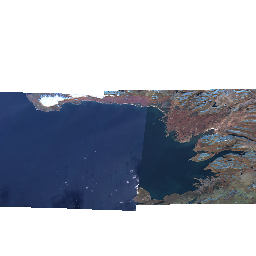

In [27]:
MAPS_API_URL = f"https://maps.{base_domain}"
import requests
from PIL import Image
from IPython.display import display
import io
params = {
    "bbox": "-24.36,63.49,-21.28,65.69",
    "datetime": "2023-10-31T00:00:00Z/2023-11-08T23:59:59Z",
    "width": 256,
    "height": 256,
}
response = requests.get(f"{MAPS_API_URL}/collections/{collection}/map", params=params)
response.raise_for_status()
img = Image.open(io.BytesIO(response.content))
display(img)

In [ ]:
collection = "sentinel-2-l2a-render"
style = "ndvi"
params = {
    "bbox": "-22,64,-21.7,64.3",
    "datetime": "2023-10-31T00:00:00Z/2023-10-31T23:59:59Z",
    "width": 256,
    "height": 256,
}
response = requests.get(f"{MAPS_API_URL}/collections/{collection}/styles/{style}/map", params=params)
response.raise_for_status()
img = Image.open(io.BytesIO(response.content))
display(img)

## (Paused) Data Analysis with Coverages (OGC API Coverages)

In [ ]:
# COV_API_URL = f"https://stacture.{base_domain}"
# import requests
# from rasterio.io import MemoryFile
# COV_COLLECTIONS = f"{COV_API_URL}/collections"
# resp = requests.get(COV_COLLECTIONS).json()
# for collection in resp['collections']:
#     print("####")
#     print(collection['title'])
#     print(collection['id'])

# collection_id = collection['id']
# COLLECTION_URL = f"{COV_API_URL}/collections/{collection_id}"
# resp = requests.get(COLLECTION_URL).json()
# print(resp["description"])
# print(resp['extent'])
# COVERAGE_URL = f"{COLLECTION_URL}/coverage"
# params = {
#     "bbox": "18.5,52.4,18.7,52.7",
#     "datetime": "2023-12-31T10:00:00Z/2023-12-31T10:05:00Z",
#     "bbox-crs": "EPSG:4326",
#     "width": 512,
#     "height": 512,
#     "f": "image/tiff",
# }
# resp = requests.get(COVERAGE_URL, params=params)
# resp
# with MemoryFile(resp.content) as memfile:
#     with memfile.open() as dataset:
#         print("BBOX:", dataset.bounds)
#         print("CRS:", dataset.crs)
#         data_array = dataset.read()

# print("SHAPE:", data_array.shape)
# print("MIN:", data_array.min())
# print("MAX:", data_array.max())
# print("MEAN:", data_array.mean())
# print("STDEV:", data_array.std())
# SCENES = f"{COV_API_URL}/collections/{collection_id}/scenes"
# resp = requests.get(SCENES).json()
# for scene in resp['scenes']:
#     print(scene)